<a href="https://colab.research.google.com/github/arjunsshah/Physics-Informed-Neural-Nets/blob/main/PINNS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Comparison of PINN-based PDE solver on Different PDEs**


- **Author:** Yiming Wang, Arjun Shah, Hao Feng
- **Abstract:** Many times in machine learning, we seek to make predictions of data and by using our previous knowledge of our dataset (priors), we can better estimate our results. We conduct a series of experiments in solving partial differential equations (PDEs) through physics-informed neural networks (PINNs). PINNs incorporates the physical constraints and laws of our environment which allows for better predictions in scientific data sets. We first analyze solving PDEs using simple methods such as Linear Regression and Polynomial Regression to solve the "Zero-dimension" diffusion equation. We improve upon this by using a fully connected neural network (FNN) and develop it further by utilizing penalty-free neural networks (PFNN) and residual neural networks (ResNet). We apply all these methods to different PDEs including the fractional 1D/2D/3D Poisson equation which does not have an analytical solution. We found that simple models such as linear and polynomial regression resulted in a high $L_2$ loss of 1.524 and 0.317, respectively. For the 1D diffusion equation, we found that our three NN methods performed roughly the same with a test loss of 1.81e-04, 2.63e-04, and 2.63e-04 for FNN, PFNN, and ResNet respectively. We also observed differences in our test loss when we changed the dimension size of our PDE: notably, our test loss for the Poisson Equation for the dimensions 1, 2, and 3 were 5.74e-07, 2.41e-05, and 1.16e-03. While the PINNs method for solving PDEs is computationally expensive for higher dimensional data sets, it is a powerful method for approximating solutions to PDEs even if the PDE does not have an analytical solution. There are multiple paths for future work with PINNs such as finding discrepancies between different formed PDEs, solving the inverse problem for medical image reconstruction, and for combining PINNs with boosting techniques to improve high-dimensional accuracy.


In [ ]:
"""
Import libraries
"""
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import random
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

#We use DeepXDE framework as our solver
#https://github.com/lululxvi/deepxde
!pip install deepxde
import deepxde as dde
from deepxde.backend import tf
from scipy.special import gamma

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 144 kB 4.6 MB/s 
     |████████████████████████████████| 100 kB 10.4 MB/s 


DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



**We first define Linear Regression and Polynomial Regression function.**




In [ ]:
def LinearRegressionScikit(X_train, y_train, X_test, y_test):
    clf = LinearRegression().fit(X_train, y_train)
    w = clf.coef_
    b = clf.intercept_
    y_pred = clf.predict(X_test)
    delta = y_test - y_pred
    loss = LA.norm(delta)
    
    return w,b,loss

In [ ]:
def Polynomial(X_train, y_train, X_test, y_test):
    quadratic_featurizer = PolynomialFeatures(degree=3)
    X_train_quadratic = quadratic_featurizer.fit_transform(X_train)
    X_test_quadratic = quadratic_featurizer.transform(X_test)
    regressor_quadratic = LinearRegression()
    regressor_quadratic.fit(X_train_quadratic, y_train)
    w = regressor_quadratic.coef_
    b = regressor_quadratic.intercept_
    y_pred = regressor_quadratic.predict(X_test_quadratic)
    delta = y_test - y_pred
    loss = LA.norm(delta)
    
    return w,b,loss

**It is hard to use Linear model to fit PDEs (non-linear function), so in order to simlify the problem, we create a so-called "zero-dimension" diffusion equation, which is actually the diagonal line of the 1D diffusion equation.**

$y = \sin(\pi * X) * \exp(-T)$

In [ ]:
T = np.arange(0,1,0.01)
X = np.arange(-1,1,0.02)
a =  np.zeros((100,2))
a[:,0] = T
a[:,1] = X

y = np.sin(np.pi * X) * np.exp(-T)
X_train, X_test, y_train, y_test = train_test_split(a, y, test_size=0.3, random_state=42)

[0.23381526 0.46763053]
-0.20885987144693557
1.5240916465100331


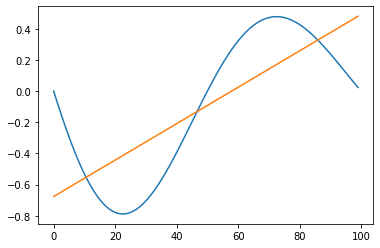

In [ ]:
w,b,loss_Linear = LinearRegressionScikit(X_train, y_train, X_test, y_test)
print(w)
print(b)
print(loss_Linear)
y_pred = w[0]*T+w[1]*X+b
plt.plot(y)
plt.plot(y_pred)
plt.show()

[ 0.          0.48262367  0.96524734  0.47092215  0.45922063 -0.04680608
  0.16573767 -0.1394468  -0.73811423 -1.42942238]
-0.44797388504871843
0.3168061184899531


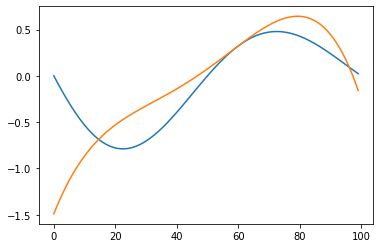

In [ ]:
w,b,loss_Polynomial = Polynomial(X_train, y_train, X_test, y_test)
print(w)
print(b)
print(loss_Polynomial)
y_pred = w[0]+w[1]*T+w[2]*T**2+w[3]*T**3+w[4]*T**4+w[5]+w[6]*X
               +w[7]*X**2+w[8]*X**3+w[9]*X**4+b
plt.plot(y)
plt.plot(y_pred)
plt.show()

**We define 1D Diffusion Equation and train FNN, PFNN, ResNet model**

1D Diffusion Equation: $ \frac{\partial y}{\partial t} = \frac{\partial^{2} y}{\partial x^{2}}$

ICs and BCs: $y = \sin(\pi  x) * \exp(-t)$

Geometry Interval $[-1,1]$, Time Interval $[0,1]$

PDE loss function: $\text{Loss}_{\text{R}} = \frac{\partial y}{\partial t} - \frac{\partial^{2} y}{\partial x^{2}} + e^{-t}*(\sin(\pi  x) - \pi^{2}  \sin(\pi  x))$

All neural networks model have the same structure: $[2] + [20] * 3 + [1]$

Solver: $ \textbf{Adam}$, Learning rate: $1*10^{3}$, Maxium Iterations: $20000$, Loss: $L_{2}$, activation: $\textbf{tanh}$

In [ ]:
#1D Diffusion Equation
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, j=1)
    dy_xx = dde.grad.hessian(y, x, j=0)
    return (
        dy_t
        - dy_xx
        + tf.exp(-x[:, 1:])
        * (tf.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * tf.sin(np.pi * x[:, 0:1]))
    )


def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    solution=func,
    num_test=10000,
)

**Feedforward Neural Network (FNN)**

Compiling model...
Building feed-forward neural network...
'build' took 0.064121 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.792040 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.54e+01, 2.04e-02, 5.00e-01]    [1.63e+01, 2.04e-02, 5.00e-01]    [1.02e+00]    
1000      [6.64e-03, 5.18e-03, 7.37e-04]    [8.42e-03, 5.18e-03, 7.37e-04]    [8.89e-02]    
2000      [1.48e-03, 1.20e-03, 5.08e-04]    [4.00e-03, 1.20e-03, 5.08e-04]    [4.70e-02]    
3000      [6.75e-04, 5.85e-04, 2.14e-04]    [1.92e-03, 5.85e-04, 2.14e-04]    [3.56e-02]    
4000      [4.96e-04, 2.61e-04, 8.46e-05]    [1.49e-03, 2.61e-04, 8.46e-05]    [2.56e-02]    
5000      [3.44e-04, 1.14e-04, 3.46e-05]    [1.15e-03, 1.14e-04, 3.46e-05]    [1.82e-02]    
6000      [2.18e-04, 5.04e-05, 1.56e-05]    [8.49e-04, 5.04e-05, 1.56e-05]    [1.34e-02]    
7000      [6.40e-04, 4.23e-05, 2.01e-05]    [1.09e-03, 4.23e-05, 2.01e-05]    [1.17e-02]    
8000      [1.12e-04, 1.78e-05, 4.77e-06]    [5.25e-04, 1.78e-05, 4.77e-06]    [8.99e-03]   

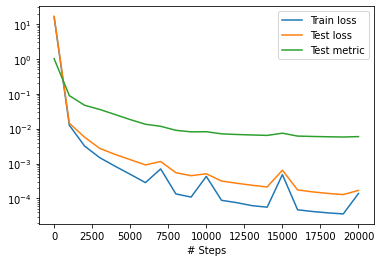

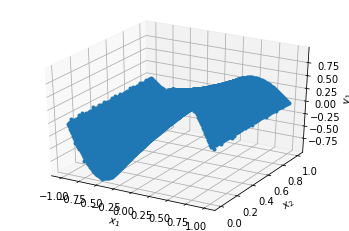

In [ ]:
layer_size = [2] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model1 = dde.Model(data, net)

model1.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model1.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

**Penalty-Free Neural Network (PFNN)**

Compiling model...
Building feed-forward neural network...
'build' took 0.059351 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.839072 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.68e+01, 4.06e-01, 9.92e-01]    [1.76e+01, 4.06e-01, 9.92e-01]    [1.68e+00]    
1000      [4.79e-03, 7.13e-03, 7.52e-04]    [7.38e-03, 7.13e-03, 7.52e-04]    [1.18e-01]    
2000      [1.80e-03, 2.17e-03, 6.42e-04]    [3.62e-03, 2.17e-03, 6.42e-04]    [6.31e-02]    
3000      [9.90e-04, 8.77e-04, 3.14e-04]    [2.16e-03, 8.77e-04, 3.14e-04]    [3.92e-02]    
4000      [1.65e-03, 2.44e-04, 9.36e-05]    [1.57e-03, 2.44e-04, 9.36e-05]    [2.20e-02]    
5000      [2.98e-04, 5.20e-05, 1.39e-05]    [6.34e-04, 5.20e-05, 1.39e-05]    [9.46e-03]    
6000      [1.86e-04, 4.00e-05, 4.92e-06]    [4.53e-04, 4.00e-05, 4.92e-06]    [7.78e-03]    
7000      [1.60e-04, 3.72e-05, 3.39e-06]    [3.83e-04, 3.72e-05, 3.39e-06]    [7.58e-03]    
8000      [9.79e-05, 3.26e-05, 2.22e-06]    [3.28e-04, 3.26e-05, 2.22e-06]    [7.17e-03]   

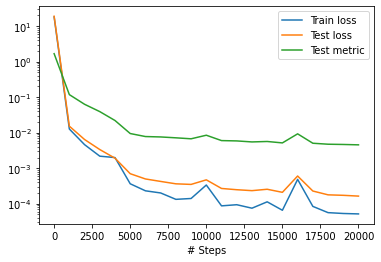

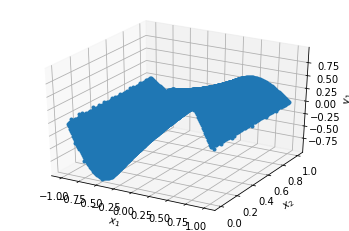

In [ ]:
layer_size = [2] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.PFNN(layer_size, activation, initializer)

model2 = dde.Model(data, net)

model2.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model2.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

**Residual Neural Network (ResNet)**

Compiling model...
Building residual neural network...
'build' took 0.087136 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/resnet.py:64: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.218200 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [1.70e+01, 6.52e-02, 4.53e-01]    [1.91e+01, 6.52e-02, 4.53e-01]    [1.24e+00]    
1000      [4.80e-03, 5.28e-03, 1.11e-03]    [7.11e-03, 5.28e-03, 1.11e-03]    [9.79e-02]    
2000      [2.63e-03, 1.80e-03, 4.45e-04]    [3.92e-03, 1.80e-03, 4.45e-04]    [6.10e-02]    
3000      [7.95e-04, 5.55e-04, 1.39e-04]    [1.02e-03, 5.55e-04, 1.39e-04]    [3.63e-02]    
4000      [1.78e-04, 9.96e-05, 3.36e-05]    [2.42e-04, 9.96e-05, 3.36e-05]    [1.68e-02]    
5000      [4.33e-04, 5.81e-05, 1.96e-05]    [3.55e-04, 5.81e-05, 1.96e-05]    [1.21e-02]    
6000      [6.67e-05, 1.62e-05, 1.17e-05]    [1.03e-04, 1.62e-05, 1.17e-05]    [6.22e-03]    
7000      [3.76e-04, 4.78e-05, 1.59e-05]    [2.32e-04, 4.78e-05, 1.59e-05]    [9.99e-03]    
8000      [2.59e-05, 1.11e-05, 8.98e-06]    [7.67e-05, 1.11e-05, 8.98e-06]    [5.01e-03]   

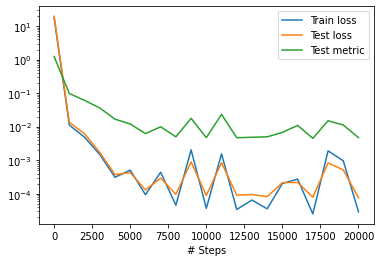

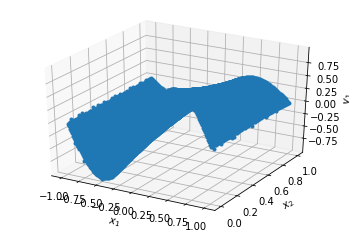

In [ ]:
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.ResNet(2, 1, 20, 2, activation, initializer)

model3 = dde.Model(data, net)

model3.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model3.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

**Fractional Poisson Equation**

Fractional Poisson Equation: $D_{\theta}^{\alpha} \varphi = 0$

Solver: $ \textbf{Adam}$, Learning rate: $1*10^{3}$, Maxium Iterations: $30000$, Loss: $L_{2}$, activation: $\textbf{tanh}$

Randomly set 1000 points to test the model and calculate the loss

**1D Fractional Poisson Equation**: PFNN structure: $[1] + [16] * 3 + [1]$

Compiling model...
Building feed-forward neural network...
'build' took 0.057369 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Generating sparse fractional matrix...
Generating sparse fractional matrix...
'compile' took 1.376564 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [9.81e-02, 0.00e+00]    [1.13e-01, 0.00e+00]    []  
1000      [6.83e-04, 0.00e+00]    [2.35e-03, 0.00e+00]    []  
2000      [5.65e-04, 0.00e+00]    [1.70e-03, 0.00e+00]    []  
3000      [4.98e-04, 0.00e+00]    [1.85e-03, 0.00e+00]    []  
4000      [3.79e-04, 0.00e+00]    [1.24e-03, 0.00e+00]    []  
5000      [2.54e-04, 0.00e+00]    [8.09e-04, 0.00e+00]    []  
6000      [1.17e-04, 0.00e+00]    [4.74e-04, 0.00e+00]    []  
7000      [9.57e-06, 0.00e+00]    [5.76e-05, 0.00e+00]    []  
8000      [2.09e-05, 0.00e+00]    [6.74e-05, 0.00e+00]    []  
9000      [2.07e-05, 0.00e+00]    [6.80e-05, 0.00e+00]    []  
10000     [1.20e-05, 0.00e+00]    [4.87e-05, 0.00e+00]    []  
11000     [3.39e-05, 0.00e+00]    [1.44e-04, 0.00e+00]    []  
12000     [1.09e-04, 0.0

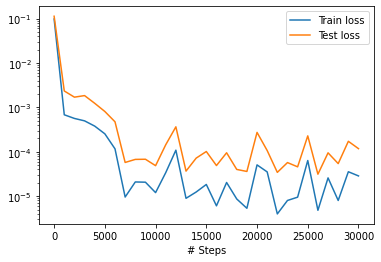

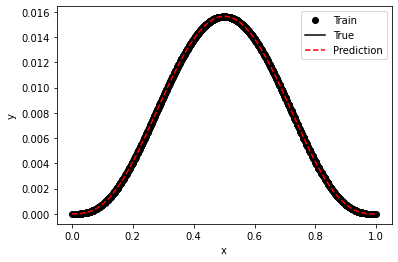

L2 relative error: 0.010159143


In [ ]:
alpha = 1.8

def fpde(x, y, int_mat):
    if isinstance(int_mat, (list, tuple)) and len(int_mat) == 3:
        int_mat = tf.SparseTensor(*int_mat)
        lhs = tf.sparse_tensor_dense_matmul(int_mat, y)
    else:
        lhs = tf.matmul(int_mat, y)
    rhs = (
        gamma(4) / gamma(4 - alpha) * (x ** (3 - alpha) + (1 - x) ** (3 - alpha))
        - 3 * gamma(5) / gamma(5 - alpha) * (x ** (4 - alpha) + (1 - x) ** (4 - alpha))
        + 3 * gamma(6) / gamma(6 - alpha) * (x ** (5 - alpha) + (1 - x) ** (5 - alpha))
        - gamma(7) / gamma(7 - alpha) * (x ** (6 - alpha) + (1 - x) ** (6 - alpha))
    )
    return lhs - rhs[: tf.size(lhs)]

def func(x):
    return x ** 3 * (1 - x) ** 3

geom = dde.geometry.Interval(0, 1)
bc = dde.icbc.DirichletBC(geom, func, lambda _, on_boundary: on_boundary)

# Dynamic auxiliary points
data = dde.data.FPDE(
     geom, fpde, alpha, bc, [100], meshtype="dynamic", num_domain=20, num_boundary=2, solution=func, num_test=1000
)

net = dde.nn.PFNN([1] + [16] * 3 + [1], "tanh", "Glorot normal")
net.apply_output_transform(lambda x, y: x * (1 - x) * y)

model4 = dde.Model(data, net)
model4.compile("adam", lr=1e-3)
losshistory, train_state = model4.train(iterations=30000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X = geom.random_points(1000)
y_true = func(X)
y_pred = model4.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test4.dat", np.hstack((X, y_true, y_pred)))

**2D Fractional Poisson Equation**

PFNN structure: $[2] + [16] * 3 + [1]$

Compiling model...
Building feed-forward neural network...
'build' took 0.062425 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Generating sparse fractional matrix...
Generating sparse fractional matrix...
'compile' took 1.573267 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.25e+01, 0.00e+00]    [1.25e+01, 0.00e+00]    []  
1000      [2.89e-02, 0.00e+00]    [2.89e-02, 0.00e+00]    []  
2000      [1.47e-02, 0.00e+00]    [1.47e-02, 0.00e+00]    []  
3000      [6.78e-03, 0.00e+00]    [6.78e-03, 0.00e+00]    []  
4000      [3.86e-03, 0.00e+00]    [3.85e-03, 0.00e+00]    []  
5000      [2.29e-03, 0.00e+00]    [2.29e-03, 0.00e+00]    []  
6000      [1.04e-03, 0.00e+00]    [1.04e-03, 0.00e+00]    []  
7000      [7.59e-04, 0.00e+00]    [7.60e-04, 0.00e+00]    []  
8000      [5.83e-04, 0.00e+00]    [5.83e-04, 0.00e+00]    []  
9000      [4.16e-04, 0.00e+00]    [4.15e-04, 0.00e+00]    []  
10000     [3.60e-04, 0.00e+00]    [3.60e-04, 0.00e+00]    []  
11000     [3.03e-04, 0.00e+00]    [3.02e-04, 0.00e+00]    []  
12000     [2.90e-04, 0.0

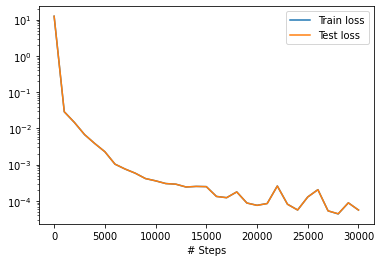

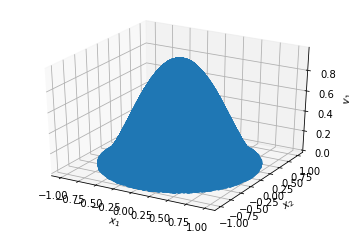

L2 relative error: 0.0007409764


In [ ]:
alpha = 1.8

def fpde(x, y, int_mat):
    if isinstance(int_mat, (list, tuple)) and len(int_mat) == 3:
        int_mat = tf.SparseTensor(*int_mat)
        lhs = tf.sparse_tensor_dense_matmul(int_mat, y)
    else:
        lhs = tf.matmul(int_mat, y)
    lhs = lhs[:, 0]
    lhs *= gamma((1 - alpha) / 2) * gamma((2 + alpha) / 2) / (2 * np.pi ** 1.5)
    x = x[: tf.size(lhs)]
    rhs = (
        2 ** alpha
        * gamma(2 + alpha / 2)
        * gamma(1 + alpha / 2)
        * (1 - (1 + alpha / 2) * tf.reduce_sum(x ** 2, axis=1))
    )
    return lhs - rhs


def func(x):
    return (np.abs(1 - np.linalg.norm(x, axis=1, keepdims=True) ** 2)) ** (
        1 + alpha / 2
    )


geom = dde.geometry.Disk([0, 0], 1)
bc = dde.icbc.DirichletBC(geom, func, lambda _, on_boundary: on_boundary)
data = dde.data.FPDE(
    geom, fpde, alpha, bc, [8, 100], num_domain=100, num_boundary=1, solution=func
)

net = dde.nn.PFNN([2] + [16] * 3 + [1], "tanh", "Glorot normal")
net.apply_output_transform(
    lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
)

model6 = dde.Model(data, net)
model6.compile("adam", lr=1e-3)
losshistory, train_state = model6.train(iterations=30000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X = geom.random_points(1000)
y_true = func(X)
y_pred = model6.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test6.dat", np.hstack((X, y_true, y_pred)))

PFNN structure: $[2] + [16] * 4 + [1]$

Compiling model...
Building feed-forward neural network...
'build' took 0.073867 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Generating sparse fractional matrix...
Generating sparse fractional matrix...
'compile' took 1.436205 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.78e+01, 0.00e+00]    [1.78e+01, 0.00e+00]    []  
1000      [3.05e-02, 0.00e+00]    [3.05e-02, 0.00e+00]    []  
2000      [1.21e-02, 0.00e+00]    [1.21e-02, 0.00e+00]    []  
3000      [4.02e-03, 0.00e+00]    [4.02e-03, 0.00e+00]    []  
4000      [2.67e-03, 0.00e+00]    [2.66e-03, 0.00e+00]    []  
5000      [1.74e-03, 0.00e+00]    [1.74e-03, 0.00e+00]    []  
6000      [1.03e-03, 0.00e+00]    [1.03e-03, 0.00e+00]    []  
7000      [4.46e-04, 0.00e+00]    [4.47e-04, 0.00e+00]    []  
8000      [3.82e-04, 0.00e+00]    [3.82e-04, 0.00e+00]    []  
9000      [2.37e-04, 0.00e+00]    [2.37e-04, 0.00e+00]    []  
10000     [2.32e-04, 0.00e+00]    [2.31e-04, 0.00e+00]    []  
11000     [1.55e-04, 0.00e+00]    [1.55e-04, 0.00e+00]    []  
12000     [1.56e-04, 0.0

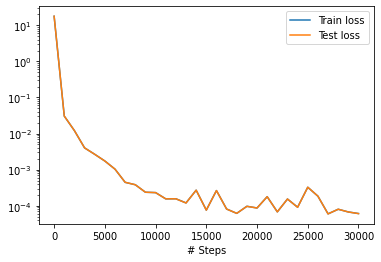

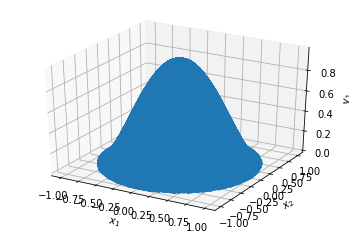

L2 relative error: 0.0025195645


In [ ]:
net = dde.nn.PFNN([2] + [16] * 4 + [1], "tanh", "Glorot normal")
net.apply_output_transform(
    lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
)

model7 = dde.Model(data, net)
model7.compile("adam", lr=1e-3)
losshistory, train_state = model7.train(iterations=30000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X = geom.random_points(1000)
y_true = func(X)
y_pred = model7.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test7.dat", np.hstack((X, y_true, y_pred)))

PFNN structure: $[2] +[16]*3+[8]*2+[1]$

Compiling model...
Building feed-forward neural network...
'build' took 0.088518 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Generating sparse fractional matrix...
Generating sparse fractional matrix...
'compile' took 1.493484 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.26e+01, 0.00e+00]    [1.26e+01, 0.00e+00]    []  
1000      [2.33e-02, 0.00e+00]    [2.33e-02, 0.00e+00]    []  
2000      [4.02e-03, 0.00e+00]    [4.02e-03, 0.00e+00]    []  
3000      [1.25e-03, 0.00e+00]    [1.25e-03, 0.00e+00]    []  
4000      [7.02e-04, 0.00e+00]    [7.02e-04, 0.00e+00]    []  
5000      [6.14e-04, 0.00e+00]    [6.13e-04, 0.00e+00]    []  
6000      [5.71e-04, 0.00e+00]    [5.70e-04, 0.00e+00]    []  
7000      [2.99e-04, 0.00e+00]    [2.99e-04, 0.00e+00]    []  
8000      [2.55e-04, 0.00e+00]    [2.55e-04, 0.00e+00]    []  
9000      [3.21e-04, 0.00e+00]    [3.21e-04, 0.00e+00]    []  
10000     [1.33e-04, 0.00e+00]    [1.33e-04, 0.00e+00]    []  
11000     [8.64e-05, 0.00e+00]    [8.63e-05, 0.00e+00]    []  
12000     [6.79e-05, 0.0

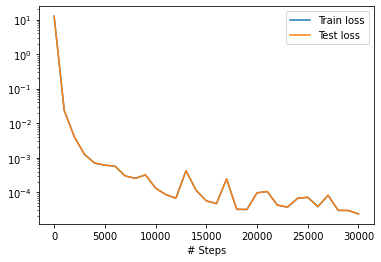

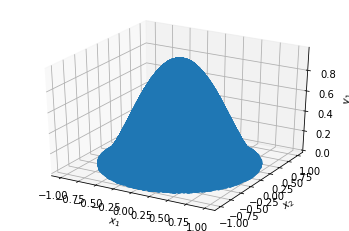

L2 relative error: 0.001690611


In [ ]:
net = dde.nn.PFNN([2] + [16] * 3 + [8]*2 + [1], "tanh", "Glorot normal")
net.apply_output_transform(
    lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
)

model8 = dde.Model(data, net)
model8.compile("adam", lr=1e-3)
losshistory, train_state = model8.train(iterations=30000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

X = geom.random_points(1000)
y_true = func(X)
y_pred = model8.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test8.dat", np.hstack((X, y_true, y_pred)))

**3D Fractional Poisson Equation**

PFNN structure: $[2] +[16]*3+[1]$

Compiling model...
Building feed-forward neural network...
'build' took 0.059391 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Generating sparse fractional matrix...
Generating sparse fractional matrix...
'compile' took 11.892122 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.12e+01, 0.00e+00]    [2.12e+01, 0.00e+00]    []  
1000      [1.30e-01, 0.00e+00]    [1.30e-01, 0.00e+00]    []  
2000      [3.36e-02, 0.00e+00]    [3.36e-02, 0.00e+00]    []  
3000      [2.37e-02, 0.00e+00]    [2.37e-02, 0.00e+00]    []  
4000      [1.87e-02, 0.00e+00]    [1.87e-02, 0.00e+00]    []  
5000      [1.50e-02, 0.00e+00]    [1.50e-02, 0.00e+00]    []  
6000      [1.22e-02, 0.00e+00]    [1.23e-02, 0.00e+00]    []  
7000      [9.86e-03, 0.00e+00]    [9.86e-03, 0.00e+00]    []  
8000      [1.27e-02, 0.00e+00]    [1.27e-02, 0.00e+00]    []  
9000      [1.67e-02, 0.00e+00]    [1.67e-02, 0.00e+00]    []  
10000     [5.19e-03, 0.00e+00]    [5.19e-03, 0.00e+00]    []  
11000     [4.66e-03, 0.00e+00]    [4.67e-03, 0.00e+00]    []  
12000     [4.24e-03, 0.

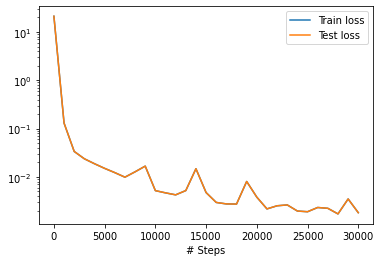

L2 relative error: 0.0055288327394689835


In [ ]:
alpha = 1.8

def fpde(x, y, int_mat):
    if isinstance(int_mat, (list, tuple)) and len(int_mat) == 3:
        int_mat = tf.SparseTensor(*int_mat)
        lhs = tf.sparse_tensor_dense_matmul(int_mat, y)
    else:
        lhs = tf.matmul(int_mat, y)
    lhs = lhs[:, 0]
    lhs *= gamma((1 - alpha) / 2) * gamma((3 + alpha) / 2) / (2 * np.pi ** 2)
    x = x[: tf.size(lhs)]
    rhs = (
        2 ** alpha
        * gamma(2 + alpha / 2)
        * gamma((3 + alpha) / 2)
        / gamma(3 / 2)
        * (1 - (1 + alpha / 3) * tf.reduce_sum(x ** 2, axis=1))
    )
    return lhs - rhs


def func(x):
    return (np.abs(1 - np.linalg.norm(x, axis=1, keepdims=True) ** 2)) ** (
        1 + alpha / 2
    )


geom = dde.geometry.Sphere([0, 0, 0], 1)
bc = dde.icbc.DirichletBC(geom, func, lambda _, on_boundary: on_boundary)

data = dde.data.FPDE(
    geom,
    fpde,
    alpha,
    bc,
    [8, 8, 100],
    num_domain=256,
    num_boundary=1,
    solution=func,
)

net = dde.nn.PFNN([3] + [16] * 3 + [1], "tanh", "Glorot normal")
net.apply_output_transform(
    lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
)

model9 = dde.Model(data, net)
model9.compile("adam", lr=1e-3)
losshistory, train_state = model9.train(iterations=30000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

X = geom.random_points(10000)
y_true = func(X)
y_pred = model9.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test9.dat", np.hstack((X, y_true, y_pred)))

PFNN structure: $[2] +[16]*3+[8]*2+[1]$

Compiling model...
Building feed-forward neural network...
'build' took 0.086022 s



/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


Generating sparse fractional matrix...
Generating sparse fractional matrix...
'compile' took 12.194502 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [3.94e+01, 0.00e+00]    [3.94e+01, 0.00e+00]    []  
1000      [9.00e-02, 0.00e+00]    [9.00e-02, 0.00e+00]    []  
2000      [3.85e-02, 0.00e+00]    [3.85e-02, 0.00e+00]    []  
3000      [2.80e-02, 0.00e+00]    [2.80e-02, 0.00e+00]    []  
4000      [2.27e-02, 0.00e+00]    [2.27e-02, 0.00e+00]    []  
5000      [2.04e-02, 0.00e+00]    [2.04e-02, 0.00e+00]    []  
6000      [1.71e-02, 0.00e+00]    [1.71e-02, 0.00e+00]    []  
7000      [1.45e-02, 0.00e+00]    [1.45e-02, 0.00e+00]    []  
8000      [1.26e-02, 0.00e+00]    [1.27e-02, 0.00e+00]    []  
9000      [1.12e-02, 0.00e+00]    [1.12e-02, 0.00e+00]    []  
10000     [9.49e-03, 0.00e+00]    [9.50e-03, 0.00e+00]    []  
11000     [2.73e-02, 0.00e+00]    [2.74e-02, 0.00e+00]    []  
12000     [7.48e-03, 0.

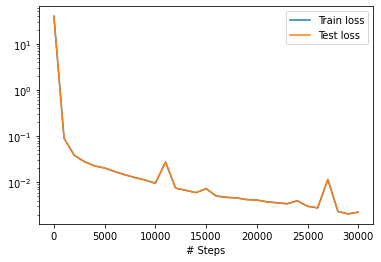

L2 relative error: 0.002640780102669897


In [ ]:
net = dde.nn.PFNN([3] + [16] * 3 + [8]*2 + [1], "tanh", "Glorot normal")
net.apply_output_transform(
    lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
)

model10 = dde.Model(data, net)
model10.compile("adam", lr=1e-3)
losshistory, train_state = model10.train(iterations=30000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

X = geom.random_points(10000)
y_true = func(X)
y_pred = model10.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test10.dat", np.hstack((X, y_true, y_pred)))

PFNN structure: $[2] +[16]*3+[8]*2+ [4]+[1]$

Compiling model...
Building feed-forward neural network...
'build' took 0.098529 s

Generating sparse fractional matrix...
Generating sparse fractional matrix...
'compile' took 11.774514 s

Initializing variables...
Training model...

0         [2.21e+01, 0.00e+00]    [2.21e+01, 0.00e+00]    []  
1000      [5.30e-02, 0.00e+00]    [5.31e-02, 0.00e+00]    []  
2000      [2.94e-02, 0.00e+00]    [2.94e-02, 0.00e+00]    []  
3000      [1.50e-02, 0.00e+00]    [1.50e-02, 0.00e+00]    []  
4000      [7.10e-03, 0.00e+00]    [7.10e-03, 0.00e+00]    []  
5000      [5.60e-03, 0.00e+00]    [5.60e-03, 0.00e+00]    []  
6000      [1.54e-02, 0.00e+00]    [1.54e-02, 0.00e+00]    []  
7000      [5.10e-03, 0.00e+00]    [5.10e-03, 0.00e+00]    []  
8000      [4.21e-03, 0.00e+00]    [4.21e-03, 0.00e+00]    []  
9000      [1.73e-02, 0.00e+00]    [1.73e-02, 0.00e+00]    []  
10000     [2.51e-03, 0.00e+00]    [2.51e-03, 0.00e+00]    []  
11000     [2.54e-03, 0.00e+00]    [2.54e-03, 0.00e+00]    []  
12000    

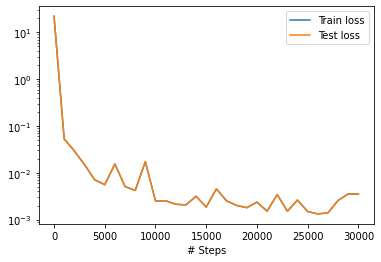

L2 relative error: 0.003294840869182833


In [ ]:
net = dde.nn.PFNN([3] + [16] * 3 + [8]*2 + [4] + [1], "tanh", "Glorot normal")
net.apply_output_transform(
    lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y
)

model11 = dde.Model(data, net)
model11.compile("adam", lr=1e-3)
losshistory, train_state = model11.train(iterations=30000)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

X = geom.random_points(10000)
y_true = func(X)
y_pred = model11.predict(X)
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test11.dat", np.hstack((X, y_true, y_pred)))